In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA

In [2]:
epoch1 = mne.read_epochs('/scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif')
epoch2 = mne.read_epochs('/scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P2-epo.fif')
epoch3 = mne.read_epochs('/scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P3-epo.fif')
epoch4 = mne.read_epochs('/scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P4-epo.fif')

Reading /scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P1-epo-1.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P1-epo-2.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /scratch/jd5697/cv_project/THINGSmeg/ds004212/derivatives/preprocessed/preprocessed_P1-epo-3.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
27048 matching events found
No baseline correction applied

In [3]:
print(epoch1.info['dev_head_t'])
print(epoch2.info['dev_head_t'])
print(epoch3.info['dev_head_t'])
print(epoch4.info['dev_head_t'])

<Transform | MEG device->head>
[[ 0.99993873  0.01098487  0.00136996 -0.00130374]
 [-0.01103947  0.99869788  0.04980663 -0.01859115]
 [-0.00082106 -0.04981871  0.99875796  0.04878354]
 [ 0.          0.          0.          1.        ]]
<Transform | MEG device->head>
[[ 0.99938017 -0.03186949  0.01495237 -0.0000166 ]
 [ 0.02921745  0.98784524  0.15266988 -0.01128569]
 [-0.01963613 -0.15213838  0.98816413  0.05878373]
 [ 0.          0.          0.          1.        ]]
<Transform | MEG device->head>
[[ 0.99950707 -0.01497871 -0.02758988  0.00235912]
 [ 0.01953502  0.98471123  0.17309572 -0.01094172]
 [ 0.02457531 -0.17354937  0.98451847  0.0569687 ]
 [ 0.          0.          0.          1.        ]]
<Transform | MEG device->head>
[[ 0.99982357 -0.01719301 -0.00756616 -0.00262063]
 [ 0.01791422  0.99390841  0.10874374 -0.00833945]
 [ 0.00565043 -0.1088601   0.99404103  0.06367525]
 [ 0.          0.          0.          1.        ]]


In [4]:
epoch2.info['dev_head_t'] = epoch1.info['dev_head_t']
epoch3.info['dev_head_t'] = epoch1.info['dev_head_t']
epoch4.info['dev_head_t'] = epoch1.info['dev_head_t']
epochs = mne.concatenate_epochs([epoch1, epoch2, epoch3, epoch4])

del epoch1, epoch2, epoch3, epoch4

Adding metadata with 18 columns
108192 matching events found
No baseline correction applied


In [5]:
#Keep only 'exp' images
indices = [i for i, x in enumerate(epochs.metadata['trial_type']) if x == 'exp']
print(len(indices))
epochs = epochs[indices]

88992


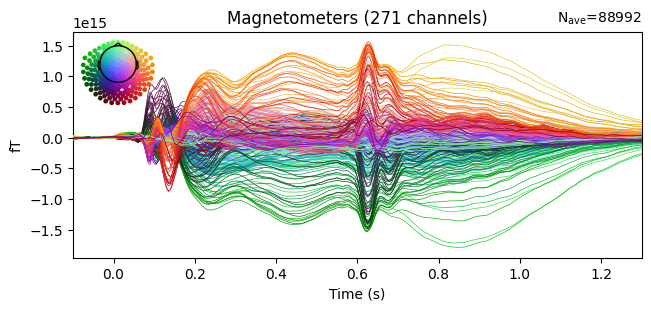

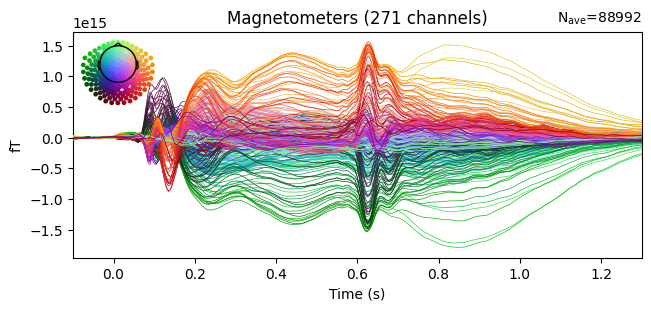

In [6]:
evoked = epochs.average()
evoked.plot()

In [7]:
peak = evoked.get_peak(time_as_index=True)
print(peak)

('MLT31-1609', 189)


In [9]:
#Get the image corresponding to the peak for all epochs
peak_responses = epochs.get_data()[:, :, peak[1]]
print(peak_responses.shape)

(88992, 271)


In [10]:
#Get the unique category numbers from the metadata along with the count of each type
categories = epochs.metadata['category_nr']
categories = np.array(categories)
categories = categories[~np.isnan(categories)]
print(categories.shape)
unique_categories, counts = np.unique(categories, return_counts=True)
print(unique_categories, counts)

#Print the unique values in category counts along with frequency of each value
unique, counts = np.unique(counts, return_counts=True)
print(unique, counts)

(88992,)
[   1    2    3 ... 1852 1853 1854] [48 48 48 ... 48 48 48]
[48] [1854]


In [11]:
concept_to_highcat = pd.read_csv('things RGB/03_category-level/category53_wide-format.tsv', sep = '\t')

#Drop the columns uniqueID and Word if they are present
if 'uniqueID' in concept_to_highcat.columns:
    concept_to_highcat = concept_to_highcat.drop(columns = ['uniqueID'])
if 'Word' in concept_to_highcat.columns:
    concept_to_highcat = concept_to_highcat.drop(columns = ['Word'])

print(concept_to_highcat.shape)
sums = concept_to_highcat.sum(axis = 0)
print(sums)

(1854, 53)
animal                    177
arts and crafts supply     44
bird                       27
body part                  34
breakfast food             35
candy                      16
clothing                  108
clothing accessory         38
condiment                  15
construction equipment     28
container                 105
dessert                    37
drink                      19
electronic device          74
farm animal                18
fastener                   32
food                      295
footwear                   15
fruit                      34
furniture                  39
game                       19
garden tool                17
hardware                   79
headwear                   19
home appliance             38
home decor                 45
insect                     17
jewelry                    15
kitchen appliance          20
kitchen tool               27
lighting                   16
mammal                     88
medical equipment          27

In [12]:
num_to_sample = sums.min()*unique
print(num_to_sample)

[720]


In [13]:
#Create a list of category pairs from columns in the concept_to_highcat dataframe
category_pairs = []
columns = concept_to_highcat.columns
for i in range(len(columns)):
    for j in range(i, len(columns)):
        category_pairs.append((columns[i], columns[j]))

print(len(category_pairs))

1431


In [14]:
#Create a dataframe for the peak responses with categories from concept_to_highcat
peak_responses_df = pd.DataFrame([[peak_responses[i]] for i in range(len(peak_responses))], columns=['image'])
peak_responses_df['category_nr'] = categories
peak_responses_df['category'] = np.array(epochs.metadata['image_path'])
peak_responses_df['category_nr'] = peak_responses_df['category_nr'].astype(int) - 1

peak_responses_df = peak_responses_df.merge(concept_to_highcat, left_on='category_nr', right_index=True)
print(peak_responses_df.head(20))

                                                image  category_nr  \
0   [2.596252138346699, 0.7827313609448368, 0.3735...         1759   
1   [2.410402025073097, 2.407750776131678, 2.56927...          576   
2   [-0.9362347984955193, -2.2522011393924686, -3....          626   
3   [0.011424349832708569, 0.10049899440320686, -0...          245   
4   [1.5678835007257703, 0.713981314487036, 0.5488...         1556   
5   [-0.1427828062724199, 0.8293731116386027, 1.56...          331   
6   [0.5386414172429426, 0.09578202991067464, -0.7...         1762   
7   [-1.5219862155296937, -0.7934710247304935, -0....         1723   
8   [-1.2963544299630598, -3.476449782545785, -2.6...          566   
9   [1.4983104180626015, 2.116835323800899, 1.9553...         1420   
10  [1.6467482992392206, 0.18598114774096786, -0.5...          438   
11  [-0.043498446390188406, -0.5616142207287211, -...         1413   
12  [-0.1009822283271582, -1.3713561955174498, -3....          700   
13  [-1.464032867587

In [15]:
#Perform PCA on the peak responses
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(peak_responses)
print(pca_result.shape)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

(88992, 50)
[0.33047755 0.11331141 0.06831346 0.05330994 0.04711981 0.04144182
 0.03244394 0.02767417 0.0257381  0.02210133 0.01773939 0.01609043
 0.01487086 0.01247169 0.01154996 0.01054649 0.01032849 0.00900928
 0.00812435 0.00689125 0.00658736 0.00585043 0.00553496 0.00497521
 0.0039762  0.00374562 0.00352964 0.00336025 0.00312311 0.00288239
 0.00279057 0.00257643 0.00253015 0.00245996 0.00232559 0.00205058
 0.00191894 0.00185188 0.00178897 0.00165052 0.00158814 0.00156563
 0.0014944  0.00133425 0.00126023 0.00116106 0.00113308 0.0011157
 0.0010877  0.00102529]
0.9578280077953004


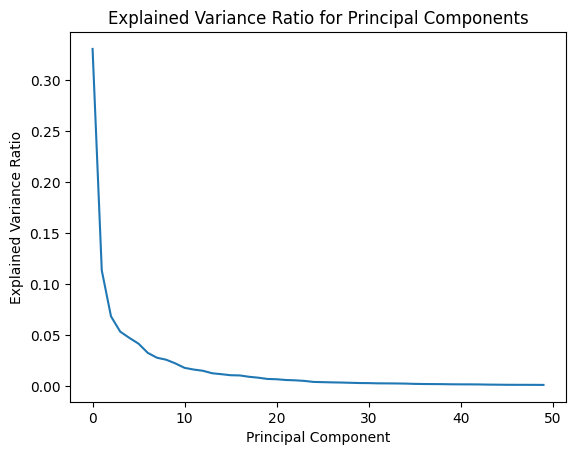

In [16]:
#Plot the explained variance ratios
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

In [17]:
#Add the PCA transformed data to the dataframe
peak_responses_df['PCA_image'] = [pca_result[i] for i in range(len(pca_result))]

In [18]:
num_clusters = [5, 10, 30, 53]

In [19]:
#Perform K means cluster on the peak responses and add the fits to the dataframe for each number of clusters
for num in num_clusters:
    #kmeans = KMeans(n_clusters=num).fit(peak_responses_df['image'].to_list())
    kmeans = KMeans(n_clusters=num).fit(peak_responses_df['PCA_image'].to_list())
    peak_responses_df['cluster' + str(num)] = kmeans.labels_

In [20]:
#Get the number of points assigned to each cluster for each number of clusters
for num in num_clusters:
    print(peak_responses_df.groupby('cluster' + str(num)).size())

cluster5
0    45098
1      434
2    38691
3     4517
4      252
dtype: int64
cluster10
0    18197
1    22644
2    15701
3      237
4     6399
5      244
6      933
7    20935
8     2398
9     1304
dtype: int64
cluster30
0     3483
1     4155
2      129
3      124
4       23
5     7387
6     4099
7     4076
8     1655
9      477
10    6009
11    1550
12       1
13     640
14    9580
15     214
16      47
17      82
18    5836
19    4565
20    1806
21    5020
22      19
23    1357
24    7968
25    5698
26      55
27      60
28    5585
29    7292
dtype: int64
cluster53
0      661
1     3415
2       55
3     1737
4      330
5     2299
6     4208
7      100
8     4234
9      154
10      41
11     358
12    1759
13    4258
14      32
15       1
16    1337
17    2193
18    4763
19       6
20     256
21     373
22    4389
23      63
24    1397
25       1
26    1969
27    3105
28     123
29      55
30    3076
31    1793
32      22
33       1
34    2703
35    3281
36    3741
37    2393
38    301

In [21]:
#Get the expect Jaccard score for random labels for each number of clusters

for num in num_clusters:

    values = [i for i in range(num)]

    random_array_1 = np.random.choice(values, 10000)
    random_array_2 = np.random.choice(values, 10000)

    print("For number of clusters: " + str(num))
    print(jaccard_score(random_array_1, random_array_2, average = 'micro'))

For number of clusters: 5
0.10539987840601338
For number of clusters: 10
0.05340777414937322
For number of clusters: 30
0.01770812131080806
For number of clusters: 53
0.010049997474875007


In [23]:
per_cluster_category_pair_scores = {}

for num in num_clusters:
    category_pair_scores = {}
    num_iterations = 20
    for i in range(num_iterations):
        for category_pair in category_pairs:
            
            filtered_df = peak_responses_df[peak_responses_df[category_pair[0]] == 1]
            sampled_category_1 =  np.array(filtered_df['cluster' + str(num)].sample(num_to_sample))
            
            filtered_df = peak_responses_df[peak_responses_df[category_pair[1]] == 1]
            sampled_category_2 =  np.array(filtered_df['cluster' + str(num)].sample(num_to_sample))

            if category_pair not in category_pair_scores:
                category_pair_scores[category_pair] = 0

            category_pair_scores[category_pair] += jaccard_score(sampled_category_1, sampled_category_2, average = 'micro')

    category_pair_scores = {k: v/num_iterations for k, v in category_pair_scores.items()}

    #Print the top 100 category pairs with the highest jaccard score
    print("For number of clusters: " + str(num) + " the top 100 most similar category pairs are:")
    print(sorted(category_pair_scores.items(), key = lambda x: x[1], reverse = True)[:100])

    #Print the top 100 category pairs with the lowest jaccard score
    print("For number of clusters: " + str(num) + " the top 100 most dissimilar category pairs are:")
    print(sorted(category_pair_scores.items(), key = lambda x: x[1], reverse = False)[:100])

    per_cluster_category_pair_scores[num] = category_pair_scores

For number of clusters: 5 the top 100 most similar category pairs are:
[(('kitchen appliance', 'kitchen appliance'), 0.3093137043949705), (('breakfast food', 'kitchen appliance'), 0.30621208066934935), (('furniture', 'kitchen appliance'), 0.30434151880020305), (('kitchen appliance', "women's clothing"), 0.3042975531848952), (('condiment', 'insect'), 0.30368158460582173), (('kitchen appliance', 'part of car'), 0.3029326163941706), (('food', 'home appliance'), 0.30272709467143966), (('food', 'plant'), 0.3023979140138743), (('home appliance', 'personal hygiene item'), 0.30201907338766754), (('dessert', 'fruit'), 0.3020008055019238), (('food', "women's clothing"), 0.3017765418440984), (('food', 'mammal'), 0.3017083687522496), (('kitchen appliance', 'weapon'), 0.3011012900561624), (('fruit', 'kitchen tool'), 0.3005969298982658), (('home appliance', 'home appliance'), 0.3005105681725534), (('headwear', 'kitchen appliance'), 0.30046064901564307), (('condiment', 'home appliance'), 0.3004240990

In [24]:
#Get the top 100 category pairs with best average rank across all number of clusters
ranks = {}
for num in num_clusters:
    i = 1
    category_pair_scores = per_cluster_category_pair_scores[num]
    sorted_category_pair_scores = sorted(category_pair_scores.items(), key = lambda x: x[1], reverse = True)
    for pair in sorted_category_pair_scores:
        if pair[0] not in ranks:
            ranks[pair[0]] = 0
        ranks[pair[0]] += i
        i += 1
    
ranks = {k: v/len(num_clusters) for k, v in ranks.items()}
print("The top 100 category pairs with the best average rank across all number of clusters are:")
print(sorted(ranks.items(), key = lambda x: x[1], reverse = False)[:100])

#Get the top 100 category pairs with worst average rank across all number of clusters
print("The top 100 category pairs with the worst average rank across all number of clusters are:")
print(sorted(ranks.items(), key = lambda x: x[1], reverse = True)[:100])

    

The top 100 category pairs with the best average rank across all number of clusters are:
[(('breakfast food', 'food'), 95.0), (('fruit', 'furniture'), 118.0), (('food', 'jewelry'), 123.5), (('jewelry', "women's clothing"), 140.5), (('breakfast food', 'fruit'), 142.0), (('fruit', 'kitchen appliance'), 172.0), (('breakfast food', 'farm animal'), 175.5), (('jewelry', 'jewelry'), 181.75), (("women's clothing", "women's clothing"), 185.25), (('food', 'insect'), 196.5), (('food', 'food'), 198.25), (('insect', 'insect'), 203.0), (('insect', 'part of car'), 206.5), (('breakfast food', 'vegetable'), 217.0), (('mammal', 'vehicle'), 219.25), (('plant', "women's clothing"), 221.75), (('kitchen tool', 'outerwear'), 222.0), (('farm animal', 'insect'), 227.25), (('drink', 'part of car'), 227.75), (('scientific equipment', "women's clothing"), 233.5), (('weapon', 'weapon'), 235.5), (('fruit', 'vegetable'), 236.25), (('toy', "women's clothing"), 237.25), (('lighting', 'mammal'), 237.5), (('plant', 'veh